<a href="https://colab.research.google.com/github/raian621/FinalProjectNLP/blob/main/FinalProjectNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary-Based Sentiment Analysis

## CSCE 4290 - Introduction to Natural Language Processing

- Ryan Bell
- Farouq Siwoku

**Contents**
1. [Introduction](#scrollTo=NyWwimvyPOTi)
  - [1.1 Problem](#scrollTo=IzaaYyYzRAvB)
  - [1.2 Importance](#scrollTo=0aopY4JIRE6x)
  - [1.3 Dataset](#scrollTo=X7IAZFhXSmZH)
  - [1.4 Proposed Methodology](#scrollTo=efdTl80eRHmm)
  - [1.5 Project Management](#scrollTo=BblVXk1DSXbk)
2. [Implementation](#scrollTo=sY3kog91Q3az)
  - [2.1 Exploratory Data Analysis](#scrollTo=rmvhO7ncSbYr)
  - [2.2 Sentiment Analysis on Entire Passages](#scrollTo=TKJSjIK2OzMr)
    - [2.2.1 Aggregate Bag of Words](#scrollTo=opEbHPEJOMrn)
  - [2.3 Sentiment Analysis on Summaries](#scrollTo=RSm_uKq6QYiI)
    - [2.3.1 Summary Feature Engineering](#scrollTo=W_rR079PQ3Zf)
    - [2.3.2 Summarized Bag of Words](#scrollTo=laz-aTE3OfEK)
3. [Results](#scrollTo=H7TLZ7lIPUng)
4. [Conclusion](#scrollTo=MrV4glZJQ61_)



## 1. Introduction

### 1.1 Problem

What is the problem we want to solve, and a hypothesis
- PERFORMANCE: Improve the performance of sentiment analysis
- HYPOTHESIS: Maybe using a summary instead of the entire text for sentiment analysis will improve the accuracy of ML model's performance.

### 1.2 Importance

- Model could be used to predict the sentiment of news stories about a stock
- Model could also be used to predict the general opinion on a product or move made by a company
- Using summaries may result in a smaller corpora, and thus bag-of-words models may consume less memory
- etc.

### 1.3 Dataset

Explain the source of the dataset, how it was compiled, the features in the dataset, what features we're planning to use, etc.

We're using the Yelp dataset from Kaggle https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset?select=yelp_academic_dataset_review.json. or https://www.yelp.com/dataset.

The Yelp dataset contains 6,990,280 user reviews of businesses. We will only use the text content and the star rating of each review. We will perform summarization on the text of each review as a form of feature extraction and also use a bag-of-words model to extract features from the text. The star rating of each review is the target that we will try to predict, which consists of 5 classes corresponding to the amount of stars each review was given on Yelp's site.

### 1.4 Proposed Methodology

Write about what models we'll use, what combination of solutions (sentiment analysis and summarization in this case) we'll employ, what features we'll use, and what kind of cross validation / train test split we'll utilize.

models:
- Summarization:
  - Some Generative Pre-trained Transformer (GPT) model(s)
  - Maybe a naive summary of just the set of the most common $N$ words?
- Sentiment Analysis:
  - Bag of Words:
    - Naive Bayes
    - Decision Tree
    - Logistic Regression
  - Word Embeddings
    - Some Bidirectional Encoder Representations from Transformer (BERT) model(s)

Summary -> Sentiment Analysis = Better Accuracy?

### Validation

We will use 5-fold cross validation to test our hypothesis that sentiment analysis on a summarized piece of text predicts the sentiment more accurately than simply performing sentiment analysis on entire text.

### Summarization

Pegasus model :::: ? Generates abstractive summaries using a transformer architecture? We will use Google's Pegasus model to generate a summary of each review as a form of feature extraction.

### Sentiment Analysis

We will use Naive Bayes, Decision Tree, and Logistic regression models with a bag-of-words representation of each entry in the corpora and also a variant of the BERT model to perform sentiment analysis on each review.

### 1.5 Project Management


Explain how the project was organized I guess. The rubric isn't clear on what this means

## 2. Implementation

In [37]:
# imports and dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from os import path

tqdm.pandas()

# natural language processing tools
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')

# metrics and train-test splitting
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
# "classic" machine learning models for classification:
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# constants
ALL_REVIEWS_JSON_PATH = 'yelp_academic_dataset_review.json'
SOME_REVIEWS_CSV_PATH = 'yelp_reviews.csv'
SOME_REVIEWS_WITH_SUMMARIES_CSV_PATH = 'yelp_reviews_with_summaries.csv'
TARGET_REVIEW_COUNT = 10000 # only use a relatively small subset of the almost 7 million reviews

[nltk_data] Downloading package stopwords to /home/ryan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.1 Exploratory Data Analysis

Load the dataset and make some fancy graphs.

In [2]:
df = pd.DataFrame()

if not path.exists(SOME_REVIEWS_CSV_PATH) and not path.exists(SOME_REVIEWS_WITH_SUMMARIES_CSV_PATH):
    chunks = []
    with open(ALL_REVIEWS_JSON_PATH, 'rb') as file:
        reader = pd.read_json(file, orient='records', lines=True, dtype={
            'stars': np.int8,
            'useful': np.int8,
            'funny': np.int8,
            'cool': np.int8
        }, chunksize=1000)

        for chunk in tqdm(reader, total=6991):
            reduced_chunk = chunk.drop(columns=['review_id', 'user_id', 'useful','funny', 'cool', 'business_id', 'date'])
            chunks.append(reduced_chunk)
        
    df = pd.concat(chunks, ignore_index=True)
    df['text'] = df['text'].apply(lambda x: x.replace('\r', ' '))
    del chunks

In [3]:
if not df.empty:
    ax = df['stars'].value_counts().sort_index().plot(
        kind='bar',
        title='Count of Reviews by Stars'
    )
    ax.set_xlabel('Review Stars')
    ax.set_ylabel('Count')
    plt.show()

In [4]:
if not df.empty:
    groups = df.groupby(['stars'], as_index=True)
    counts = {rating:groups.count()['text'][rating] for rating in range(1, 6)}
    total_count = df.shape[0]
    frequencies = {rating:(count/total_count) for rating, count in counts.items()}
    sampled_counts = {}
    
    review_count = 0
    for rating, count in counts.items():
        sampled_counts[rating] = (count * TARGET_REVIEW_COUNT) // total_count
        review_count += sampled_counts[rating]

    remainder = TARGET_REVIEW_COUNT - review_count
    
    for rating in np.random.randint(low=1, high=6, size=remainder):
        sampled_counts[rating] += 1

    df_sampled = []
    for rating, count in sampled_counts.items():
        df_sampled.append(groups.get_group((rating,)).sample(count))

    df = pd.concat(df_sampled, ignore_index=True)
    df.to_csv(SOME_REVIEWS_CSV_PATH, index=False)

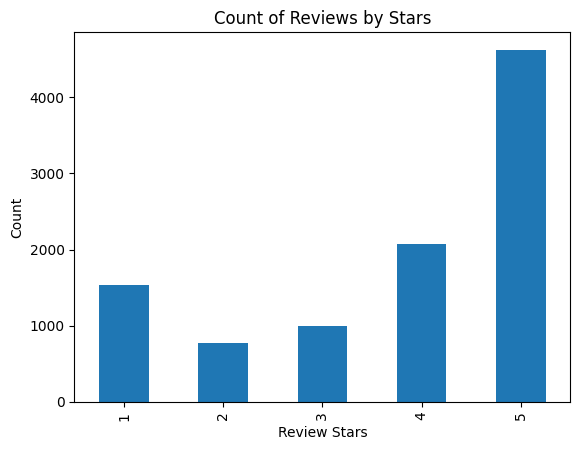

In [5]:
if df.empty:
    df = pd.read_csv(SOME_REVIEWS_CSV_PATH)

ax = df['stars'].value_counts().sort_index().plot(
    kind='bar',
    title='Count of Reviews by Stars'
)
ax.set_xlabel('Review Stars')
ax.set_ylabel('Count')
plt.show()

### 2.2 Sentiment Analysis on Entire Passages

In [69]:
ps = PorterStemmer()
def stem_tokenizer(text):
  """
  removes stopwords, tokenizes the text, and lemmatizes each token
  """
  words = word_tokenize(text)
  stemmed_words = []
  for word in words:
    word_lower = word.lower()
    if word_lower not in stopwords.words('english'):
      stemmed_words.append(word_lower)
  return stemmed_words


def get_scores(y_pred, y_target):
  return {
    'f1-score': f1_score(y_target, y_pred, average='macro'),
    'precision': precision_score(y_target, y_pred, average='macro'),
    'recall': recall_score(y_target, y_pred, average='macro'),
    'accuracy': accuracy_score(y_target, y_pred)
  }


def print_results(scores, confusion_matrix=None):
  print('f1-score: ', scores['f1-score'])
  print('precision:', scores['precision'])
  print('recall:   ', scores['recall'])
  print('accuracy: ', scores['accuracy'])
  
  if confusion_matrix:
    cm = confusion_matrix[0]
    plt.figure(figsize=(9,9))
    sns.heatmap(
      cm,
      annot=True, 
      fmt='d',
      linewidths=.5,
      square=True,
      cmap='Blues_r',
      xticklabels=[1, 2, 3, 4, 5],
      yticklabels=[1, 2, 3, 4, 5],
    )
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    title = 'Accuracy Score: {0}'.format(scores['accuracy'])
    plt.title(title, size=15)


def create_bow_kfolds(X, text_feature, folds):
  bows = []

  for fold in tqdm(folds, total=5):
    train_idx, test_idx = fold
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]

    # create bag of words representation:
    cv = CountVectorizer(tokenizer=stem_tokenizer)
    bow_train = cv.fit_transform(X_train[text_feature])
    bow_test = cv.transform(X_test[text_feature])

    bows.append((bow_train, bow_test))

  return bows


def cross_validate_bow(bow, y, clf, folds):
  total_cm = np.zeros(shape=(5,5), dtype=np.int32)
  total_scores = {}

  for i, fold in tqdm(enumerate(folds), total=5):
    train_idx, test_idx = fold
    bow_train, bow_test = bow[i]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # train and test the model
    clf.fit(bow_train, y_train)
    y_pred = clf.predict(bow_test)

    scores = get_scores(y_pred, y_test)
    cm = confusion_matrix(y_test, y_pred)

    for name, score in scores.items():
      total_scores[name] = total_scores.get(name, 0) + score

    total_cm = total_cm + cm

  total_scores = {name:score/5 for name, score in total_scores.items()}

  return total_scores, total_cm

#### 2.2.1 Aggregate Bag of Words

In [7]:
# cv = CountVectorizer(tokenizer=stem_tokenizer)
# bow = cv.fit_transform(df['text'])

In [23]:
# add bag of words features to dataframe
# df = pd.concat([df, pd.DataFrame(bow.todense(), columns=cv.get_feature_names_out())], axis=1)

In [9]:
X, y = df.drop(columns=['stars']), df['stars']

In [28]:
sgkf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
folds = []
for train_idx, test_idx in sgkf.split(X['text'], y):
    folds.append((train_idx.copy(), test_idx.copy()))
    print(train_idx.shape)

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


In [63]:
# create 5 bag of words for each fold
bow = create_bow_kfolds(X, 'text', folds)

  0%|          | 0/5 [00:00<?, ?it/s]

/home/ryan/GitHub/FinalProjectNLP/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

f1-score:  0.3995471071980473
precision: 0.4677488942243281
recall:    0.4251806577698761
accuracy:  0.6089


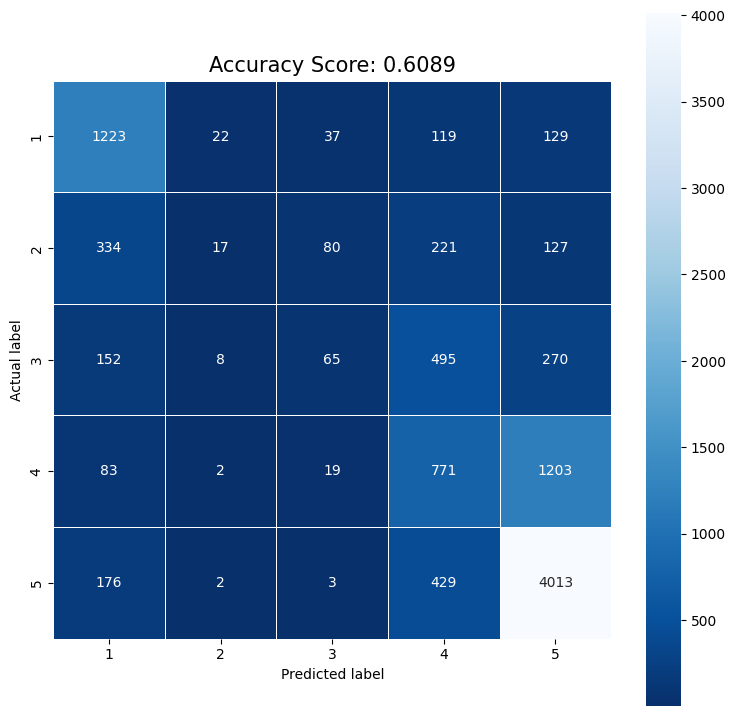

In [70]:
nb = MultinomialNB()
scores, cm = cross_validate_bow(bow, y, nb, folds)

print_results(scores, (cm,))

  0%|          | 0/5 [00:00<?, ?it/s]

/home/ryan/GitHub/FinalProjectNLP/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ryan/GitHub/FinalProjectNLP/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

f1-score:  0.4999461145458709
precision: 0.5092577017412058
recall:    0.4955243904201015
accuracy:  0.6199


/home/ryan/GitHub/FinalProjectNLP/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


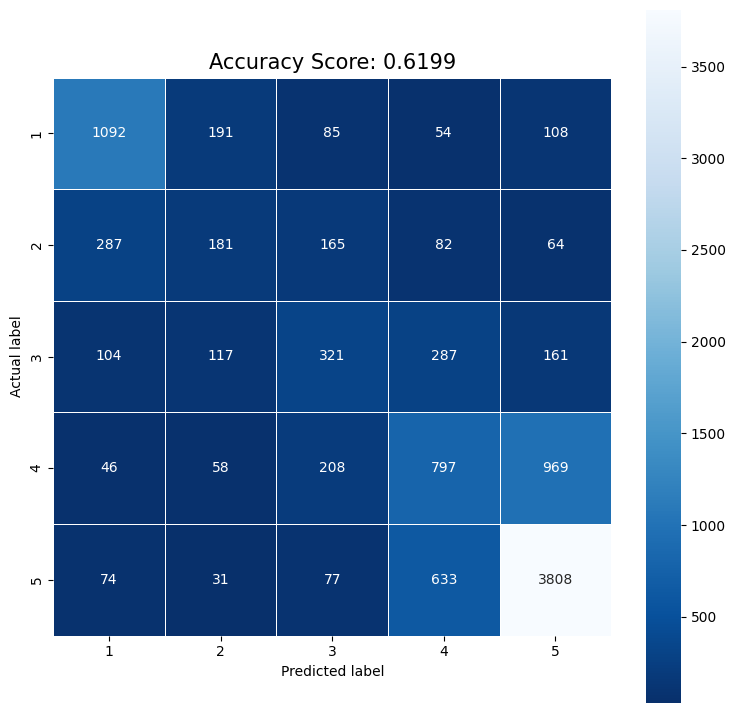

In [72]:
lgc = LogisticRegression()
scores, cm = cross_validate_bow(bow, y, lgc, folds)

print_results(scores, (cm,))

### 2.2 Sentiment Analysis on Summaries

Generate a bag of words representative of the entire corpus:

In [12]:
df.head()

,stars,text,!,#,$,%,&,','','d,...,yes,yet,yolk,young,yummmmm,yummy,zento,zucchini,~,‍
0,1,I have heard so many great things about this p...,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0 stars.\nMy wife tried to go to Patient First...,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,I was very specific on how I wanted my dogs ha...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,Very disappointed with my second time here. To...,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
4,1,"The locals call this the ""Nazi range"". \n\nThe...",5,0,0,0,0,0,3,0,...,0,0,0,1,0,0,0,0,0,0


#### 2.3.1 Summary Feature Engineering

Generate the summaries for each passage of text that we can use as a "summarized" corpora

#### 2.3.2 Summarized Bag of Words

In [7]:
%pip install  --no-cache-dir transformers sentencepiece torch tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 13.2 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 13.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 13.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 13.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 13.1 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━

Import Libraries

In [74]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm.auto import tqdm
import torch

torch_device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

Summary Generation Function

In [75]:
def generate_summary(text, tokenizer, model):
    model.to(torch_device)
    inputs = tokenizer(
        text,
        return_tensors="pt",
        max_length=1024,
        truncation=True,
        padding="max_length",
    ).to(torch_device)
    summary_ids = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=150,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True,
    )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [76]:
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast=False)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

# generate summaries
df["summary"] = df["text"].progress_apply(
    lambda x: generate_summary(x, tokenizer, model)
)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

Main Function for Processing CSV File

In [ ]:
def main(csv_file_path):
    # Load the CSV file
    data = pd.read_csv(csv_file_path).head(2)

    # Load tokenizer and model
    model_ckpt = "google/pegasus-cnn_dailymail"
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast=False)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

    # Generate summaries
    tqdm.pandas()
    data["summary"] = data["intro"].progress_apply(
        lambda x: generate_summary(x, tokenizer, model)
    )

    # Save the updated DataFrame to a new CSV file
    output_file_path = csv_file_path.replace(".csv", "_with_summaries.csv")
    data.to_csv(output_file_path, index=False)

    print(f"Updated DataFrame saved to {output_file_path}")


In [ ]:
summarized_data = pd.read_csv(output_file_path)

Analyzing the Summaries

In [12]:
# Calculate the length of the original texts and their summaries
summarized_data['original_length'] = summarized_data['intro'].apply(len)
summarized_data['summary_length'] = summarized_data['summary'].apply(len)

# Display the data with new columns
display(summarized_data[['original_length', 'summary_length']])


NameError: name 'summarized_data' is not defined

Visualization

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(summarized_data.index, summarized_data['original_length'], label='Original Length')
plt.bar(summarized_data.index, summarized_data['summary_length'], label='Summary Length', alpha=0.7)
plt.ylabel('Length of Text')
plt.title('Comparison of Original Text Length to Summary Length')
plt.legend()
plt.show()

## 3. Results

Show the final metrics for each model / combination of models

## 4. Conclusion


Conclude with a conclusion in the concluding paragraph